<a href="https://colab.research.google.com/github/smf-9000/images-through-ML/blob/main/objectDetectionApiTF%5Bexample%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import random
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2802, done.
remote: Counting objects: 100% (2802/2802), done.
remote: Compressing objects: 100% (2333/2333), done.
remote: Total 2802 (delta 717), reused 1291 (delta 433), pack-reused 0
Receiving objects: 100% (2802/2802), 32.79 MiB | 31.49 MiB/s, done.
Resolving deltas: 100% (717/717), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
%matplotlib inline

In [6]:
!mkdir /content/apples
!mkdir /content/apples/train/
!mkdir /content/apples/test/

In [7]:
train_image_dir = '/content/apples/train/'
train_images_np = []
for img_name in [f for f in os.listdir(train_image_dir) if f.endswith('.jpg')]:
  img_data = tf.io.gfile.GFile(train_image_dir + '/' + img_name, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  img_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
  train_images_np.append(img_np)

In [8]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [10]:
import math

apple_class_id = 1
num_classes = 1
category_index = {apple_class_id: {'id': apple_class_id, 'name': 'apple'}}

train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  gt_classes_one_hot_tensors.append(tf.one_hot([num_classes - 1] * math.floor(gt_box_np.size / 4), num_classes))

In [11]:
gt_classes_one_hot_tensors

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[1.],
        [1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[1.],
        [1.],
        [1.],
        [1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>]

In [12]:
gt_box_tensors

[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.50666666, 0.51529413, 0.77      , 0.8988235 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[0.6383333 , 0.6773823 , 0.965     , 0.912744  ],
        [0.09333333, 0.15499426, 0.375     , 0.35820895]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.31166667, 0.3741403 , 0.535     , 0.6011004 ]], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[0.11333334, 0.05390625, 0.5233333 , 0.303125  ],
        [0.14      , 0.30703124, 0.5133333 , 0.57734376],
        [0.01      , 0.33046874, 0.31333333, 0.5109375 ],
        [0.03333334, 0.49453124, 0.30666667, 0.659375  ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.58      , 0.38032305, 0.65166664, 0.4904552 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.21833333, 0.4774436 , 0.63166666, 1.        ]], dtype=float32)>]

In [17]:
train_image_tensors[0]

<tf.Tensor: shape=(1, 635, 425, 3), dtype=float32, numpy=
array([[[[203., 193., 191.],
         [204., 194., 192.],
         [205., 195., 193.],
         ...,
         [ 95., 103.,  90.],
         [112., 118., 106.],
         [119., 122., 111.]],

        [[204., 194., 192.],
         [204., 194., 192.],
         [205., 195., 193.],
         ...,
         [ 82.,  92.,  81.],
         [ 98., 106.,  95.],
         [105., 111., 101.]],

        [[204., 194., 192.],
         [205., 195., 193.],
         [205., 195., 193.],
         ...,
         [ 65.,  77.,  67.],
         [ 80.,  90.,  81.],
         [ 90., 100.,  91.]],

        ...,

        [[ 26.,  33.,   2.],
         [ 28.,  35.,   2.],
         [ 28.,  35.,   2.],
         ...,
         [ 23.,   8.,   1.],
         [ 25.,  10.,   3.],
         [ 26.,   9.,   2.]],

        [[ 26.,  33.,   2.],
         [ 28.,  35.,   2.],
         [ 28.,  35.,   2.],
         ...,
         [ 28.,  11.,   4.],
         [ 31.,  14.,   6.],
         

(635, 425, 3)


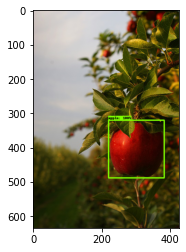

In [20]:
tmp = train_images_np[0].copy()
print(tmp.shape)
viz_utils.visualize_boxes_and_labels_on_image_array(
                                                tmp,
                                                gt_boxes[0],
                                                np.ones(shape=[gt_boxes[1].shape[0]], dtype=np.int32),
                                                np.array([1.0], dtype=np.float32),
                                                category_index,
                                                use_normalized_coordinates=True,
                                                min_score_thresh=0.8)
plt.imshow(tmp)

In [21]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-07-18 18:42:29--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.2.112, 2607:f8b0:4004:80a::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.2.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  --.-KB/s    in 0.07s   

2021-07-18 18:42:29 (261 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [30]:
tf.keras.backend.clear_session()

num_classes = 1
pipeline_config = '/content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = '/content/models/research/object_detection/test_data/checkpoint/ckpt-0' #.index'  !!!!!

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
                                  model_config=model_config, 
                                  is_training=True)

# ------------------------------------------------------------------------------
# ckpt = tf.train.Checkpoint(detection_model)
# ckpt.restore(checkpoint_path).expect_partial()
# ------------------------------------------------------------------------------
# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()
# ------------------------------------------------------------------------------

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, true_image_shapes=shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

In [ ]:
tf.train.list_variables(tf.train.latest_checkpoint('/content/models/research/object_detection/test_data/checkpoint'))

In [23]:
# If we want to know what are the attributes that are saved in checkpoint file. !!!Path is to the folder, not to the file!!!
data = tf.train.list_variables(tf.train.latest_checkpoint('/content/models/research/object_detection/test_data/checkpoint'))
M = {}
for line in data:
  line = line[0].split('/')
  i = 0
  a, b, c = '', '', ''
  for e in line:
    if i == 0:
      a = e
      if e not in M:
        M[a] = {}
    elif i == 1:
      b = e
      if e not in M[a]:
        M[a][b] = {}
    elif i == 2:
      c = e
      if e not in M[a][b]:
        M[a][b][c] = {}
    i += 1

import json
print(json.dumps(M, indent=4))

{
    "_CHECKPOINTABLE_OBJECT_GRAPH": {},
    "model": {
        "_box_predictor": {
            "_base_tower_layers_for_heads": {},
            "_box_prediction_head": {},
            "_head_scope_conv_layers": {},
            "_prediction_heads": {}
        },
        "_feature_extractor": {
            "_coarse_feature_layers": {},
            "_fpn_features_generator": {},
            "classification_backbone": {}
        }
    },
    "save_counter": {
        ".ATTRIBUTES": {
            "VARIABLE_VALUE": {}
        }
    }
}


In [24]:
trainable_variables = detection_model.trainable_variables
[e.name for e in trainable_variables]

['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/depthwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/pointwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/depthwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/pointwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/depthwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/pointwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/BatchNorm/feature_0/beta:0',
 'WeightS

In [31]:
# tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.01
num_batches = 500

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function(experimental_relax_shapes=True)
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      print('----------------------------------')
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]
  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
----------------------------------
----------------------------------
batch 0 of 500, loss=1.6300569
----------------------------------
----------------------------------
----------------------------------
batch 10 of 500, loss=0.64598185
batch 20 of 500, loss=0.47031707
batch 30 of 500, loss=0.2965454
batch 40 of 500, loss=0.15795426
batch 50 of 500, loss=0.169711
batch 60 of 500, loss=0.10884094
batch 70 of 500, loss=0.13219813
batch 80 of 500, loss=0.080641665
batch 90 of 500, loss=0.064407416
batch 100 of 500, loss=0.07544251
batch 110 of 500, loss=0.057708256
batch 120 of 500, loss=0.045865186
batch 130 of 500, loss=0.03652962
batch 140 of 500, loss=0.027691718
batch 150 of 500, loss=0.02333142
batch 160 of 500, loss=0.021850554
batch 170 of 500, loss=0.018719366
batch 180 of 500, loss=0.016376229
batch 190 of 500, loss=0.013991259
batch 200 of 500, loss=0.011288034
batch 210 of 500, loss=0.010465165
batch 220 of 500, loss=0.009315566
batch 230 of 500, loss=0.00

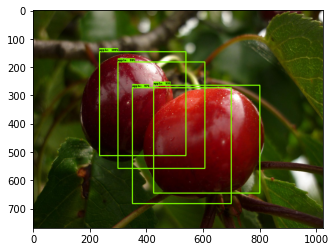

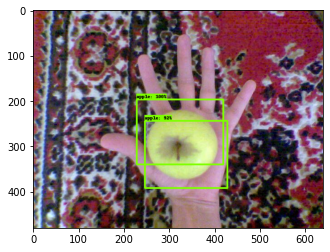

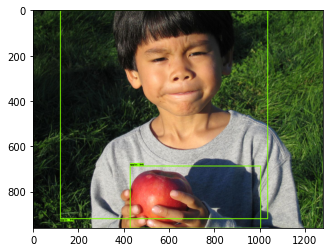

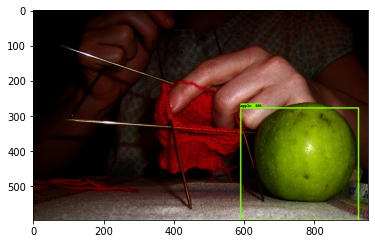

In [43]:
test_image_dir = '/content/apples/test/'
test_images_np = []
for img_name in [f for f in os.listdir(test_image_dir) if f.endswith('.jpg')]:
  if random.random() > 1:
    continue
  else:
    img_data = tf.io.gfile.GFile(test_image_dir + '/' + img_name, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    img_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    test_images_np.append(np.expand_dims(img_np, axis=0))
    # break

# Again, uncomment this decorator if you want to run inference eagerly
# @tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  tmp = test_images_np[i][0].copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
                                                  tmp,
                                                  detections['detection_boxes'][0].numpy(),
                                                  detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
                                                  detections['detection_scores'][0].numpy(),
                                                  category_index,
                                                  use_normalized_coordinates=True,
                                                  min_score_thresh=0.9)
  plt.imshow(tmp)
  plt.show()

In [ ]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices'])

In [ ]:
for k, v in detections.items():
  print('-----------------------')
  print(k)
  print('=======================')
  print(v)